### denovo missense prediction w/ feature intersection
* use positions w/ mpc **OR** pathogenic fraction
* calc path freq using counts
* total path freq
* total benign freq

In [28]:
import pandas, numpy
from scipy.stats import entropy
import pydot, pydotplus, graphviz
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn import linear_model, metrics, tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.externals.six import StringIO
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier
from IPython.display import HTML
%matplotlib inline

In [29]:
def calc_path_freq(rows):
    # sum of freqs for path
    df = rows[ (rows.clin_class=='PATHOGENIC') |
                (rows.clin_class=='LIKLEY_PATHOGENIC')]
    l = len(df)
    pathogenic_sum = sum(df['freq'])
    neg = sum(df['neg_fam'])
    if l == 0:
        return 0, 0, -1, 0
    return pathogenic_sum, pathogenic_sum/l, entropy(df['freq']/pathogenic_sum), l

def calc_benign_freq(rows):
    # sum of freqs for 
    df = rows[ (rows.clin_class=='LIKELY_BENIGN') |
                           (rows.clin_class=='BENIGN')]
    benign_sum = sum(df['freq'])
    l = len(df)
    neg = sum(df['neg_fam'])
    if l == 0:
        return 0, 0, -1, 0
    return benign_sum, benign_sum/l, entropy(df['freq']/benign_sum), l

def calc_path_frac(rows):
    pfam = list(rows['pfam'].values)[0]
    pathogenic = len(rows[ (rows.clin_class=='PATHOGENIC') | (rows.clin_class=='LIKLEY_PATHOGENIC')])
    benign = len(rows[ (rows.clin_class=='LIKELY_BENIGN') | (rows.clin_class=='BENIGN')])
    frac = -1
    if pathogenic+benign:
        frac = pathogenic/(pathogenic+benign)
    
    pf, pf_avg, pf_ent, pcount = calc_path_freq(rows)
    bf, bf_avg, bf_ent, bcount = calc_benign_freq(rows)
    
    r = -1
    if bf:
        r = pf/bf
    return pandas.Series([frac, len(rows), pf, pf_avg, pf_ent, pcount, bf, bf_avg, bf_ent, bcount, r],
                         index=['path_frac', 'size',
                                'path_freq', 'p_freq_avg', 'p_freq_ent', 'ps',
                                'benign_freq', 'b_freq_avg', 'b_freq_ent', 'bs',
                                'fRatio'])

def calc_tot_freq_ratio(rows):
    path_sum = calc_path_freq(rows)
    benign_sum = calc_benign_freq(rows)
    return path_sum/benign_sum

dat_file = '../data/interim/EPIv6.eff.dbnsfp.anno.hHack.dat.xls'
df_pre = pandas.read_csv(dat_file, sep='\t').fillna(0)
df_pre.loc[:, 'freq'] = df_pre['pos_fam']/(df_pre['pos_fam']+df_pre['neg_fam'])
df = (df_pre['pfam'].str.split(',', expand=True)
     .stack()
     .reset_index(level=0)
     .set_index('level_0')
     .rename(columns={0:'pfam'})
     .join(df_pre.drop('pfam',1), how='left')
     )
dd = df.groupby('pfam').apply(calc_path_frac)
ff = dd.reset_index()

# mk domain features
def match(row, domain_info):
    ls = []
    for pfam in row['pfam'].split(','):
        if pfam in domain_info:
            if domain_info[pfam][2] == 0:
                ls.append(domain_info[pfam])
    if len(ls) == 0:
        for pfam in row['pfam'].split(','):
            if pfam in domain_info:
                return domain_info[pfam]
        
    if len(ls):
        return ls[0]
    else:
        return (0, 0,
                0, 0, -1, 0,
                0, 0, -1, 0,
                -1, 1)
    
ff.loc[:, 'path_na'] = ff.apply(lambda row: 1 if row['path_frac']==-1 else 0, axis=1)
domain_info = {pfam:[path_frac, size,
                     path_freq, path_avg, path_ent, pc,
                     b_freq, b_avg, b_ent, bc,
                     fr, path_na]
               for pfam, path_frac, size, path_freq, path_avg, path_ent, pc, b_freq, b_avg, b_ent, bc, fr, path_na
               in ff.values}

df_pre.loc[:, 'path_frac_t'] = df_pre.apply(lambda row: match(row, domain_info)[0], axis=1)
df_pre.loc[:, 'size_t'] = df_pre.apply(lambda row: match(row, domain_info)[1], axis=1)
df_pre.loc[:, 'path_na_t'] = df_pre.apply(lambda row: match(row, domain_info)[-1], axis=1)
df_pre.loc[:, 'in_none_pfam'] = df_pre.apply(lambda row: 1 if 'none' in row['pfam'] else 0, axis=1)

# use patient counts
df_pre.loc[:, 'path_freq'] = df_pre.apply(lambda row: match(row, domain_info)[2], axis=1)
df_pre.loc[:, 'path_avg'] = df_pre.apply(lambda row: match(row, domain_info)[3], axis=1)
df_pre.loc[:, 'path_ent'] = df_pre.apply(lambda row: match(row, domain_info)[4], axis=1)
df_pre.loc[:, 'path_cnt'] = df_pre.apply(lambda row: match(row, domain_info)[5], axis=1)

df_pre.loc[:, 'benign_freq'] = df_pre.apply(lambda row: match(row, domain_info)[6], axis=1)
df_pre.loc[:, 'benign_avg'] = df_pre.apply(lambda row: match(row, domain_info)[7], axis=1)
df_pre.loc[:, 'benign_ent'] = df_pre.apply(lambda row: match(row, domain_info)[8], axis=1)
df_pre.loc[:, 'benign_cnt'] = df_pre.apply(lambda row: match(row, domain_info)[9], axis=1)

df_pre.loc[:, 'path_benign_freq_r'] = df_pre.apply(lambda row: match(row, domain_info)[10], axis=1)
#df_pre.loc[:, 'path_na_t'] = df_pre.apply(lambda row: match(row, domain_info)[2], axis=1)

In [30]:
# this is for training
# use not just missense
# I do not need to require an mpc score here anymore (df_pre.mpc>0)
df_x_pre = df_pre[ (df_pre.clin_class != 'VUS') ]
df_s = df_x_pre.groupby('pfam').size().reset_index()
multi_pfam = set( df_s[df_s[0]>1]['pfam'].values )
df_x_pre.loc[:, 'multi_pfam'] = df_x_pre.apply(lambda row: row['pfam'] in multi_pfam, axis=1)
df_x = df_x_pre[ (df_x_pre.multi_pfam) & (df_x_pre.eff=='missense_variant') & (df_x_pre.mpc>0)]
df_x.loc[:, 'y'] = df_x.apply(lambda row: 1 if row['clin_class'] in ('PATHOGENIC', 'LIKLEY_PATHOGENIC')
                            else 0, axis=1)
df_x.head()

/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam,...,path_avg,path_ent,path_cnt,benign_freq,benign_avg,benign_ent,benign_cnt,path_benign_freq_r,multi_pfam,y
12,1,40555089,G,C,PATHOGENIC,"Palm_thioest:6,Palm_thioest:7",0.000000,missense_variant,1,8544,...,0.000293,0.500402,2.0,0.000000,0.000000,-1.0,0.0,-1.0,True,1
16,1,40557070,T,A,PATHOGENIC,Palm_thioest:9,0.000599,missense_variant,2,8543,...,0.000176,0.636514,2.0,0.000000,0.000000,-1.0,0.0,-1.0,True,1
18,1,40557754,A,C,PATHOGENIC,Palm_thioest:10,0.000000,missense_variant,1,8544,...,0.000117,0.000000,1.0,0.000234,0.000234,0.0,1.0,0.5,True,1
19,1,40557769,T,C,LIKELY_BENIGN,Palm_thioest:10,0.000000,missense_variant,2,8543,...,0.000117,0.000000,1.0,0.000234,0.000234,0.0,1.0,0.5,True,0
34,1,43393355,C,T,PATHOGENIC,"MFS_1:44,Sugar_tr:29",0.000000,missense_variant,1,8419,...,0.000148,1.332179,4.0,0.000000,0.000000,-1.0,0.0,-1.0,True,1


In [31]:
train_keys = {':'.join([str(x) for x in v]):True for v in df_x[['chrom', 'pos', 'ref', 'alt']].values}
print(len(train_keys))

744


/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(array([0, 1]), <a list of 2 Text xticklabel objects>)

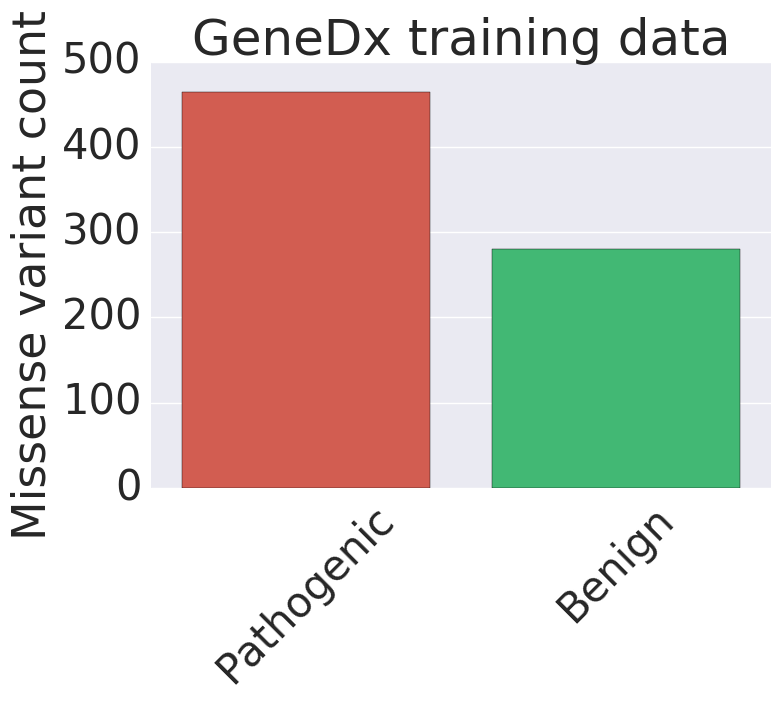

In [32]:
hash={'LIKELY_BENIGN':'Benign',
      'BENIGN':'Benign',
      'PATHOGENIC':'Pathogenic',
      'LIKLEY_PATHOGENIC':'Pathogenic'
     }
df_x.loc[:, 'plot_class'] = df_x.apply(lambda row: hash[row['clin_class']], axis=1)
flatui = ["#e74c3c", "#2ecc71"]
sns.set(font_scale=3)
ax = sns.countplot(x="plot_class", data=df_x, palette=sns.color_palette(flatui))
ax.set_ylabel('Missense variant count')
ax.set_xlabel('')
ax.set_title('GeneDx training data')
plt.xticks(rotation=45)
#ax.set_xticklabels(rotation=30)

In [35]:
clin_file = '../data/interim/denovo/denovo.dat'
clinvar_df_pre = pandas.read_csv(clin_file, sep='\t').fillna(0)

focus_gene_ls = ('SCN1A','SCN2A','KCNQ2', 'KCNQ3', 'CDKL5', 'PCDH19', 'SCN1B', 'SCN8A', 'SLC2A1', 'SPTAN1', 'STXBP1', 'TSC1')
clinvar_df_pre.loc[:, "key"] = clinvar_df_pre.apply(lambda row: ':'.join([str(row[x]) for x in ['chrom', 'pos', 'ref', 'alt']]), axis=1)
clinvar_df_pre.loc[:, "not_in_training"] = clinvar_df_pre.apply(lambda row: not row['key'] in train_keys, axis=1)
clinvar_df_pre.loc[:, "is_focus"] = clinvar_df_pre.apply(lambda row: row['gene'] in focus_gene_ls, axis=1)

clinvar_df = clinvar_df_pre[(clinvar_df_pre.eff=='missense_variant')
                            & (clinvar_df_pre.not_in_training)
                            & (clinvar_df_pre.mpc>0)
                            & (clinvar_df_pre.is_focus)].drop_duplicates()
clinvar_df.loc[:, 'path_frac_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[0], axis=1)
clinvar_df.loc[:, 'size_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[1], axis=1)
clinvar_df.loc[:, 'path_freq'] = clinvar_df.apply(lambda row: match(row, domain_info)[2], axis=1)
clinvar_df.loc[:, 'path_avg'] = clinvar_df.apply(lambda row: match(row, domain_info)[3], axis=1)
clinvar_df.loc[:, 'path_ent'] = clinvar_df.apply(lambda row: match(row, domain_info)[4], axis=1)
clinvar_df.loc[:, 'path_cnt'] = clinvar_df.apply(lambda row: match(row, domain_info)[5], axis=1)
clinvar_df.loc[:, 'benign_freq'] = clinvar_df.apply(lambda row: match(row, domain_info)[6], axis=1)
clinvar_df.loc[:, 'benign_avg'] = clinvar_df.apply(lambda row: match(row, domain_info)[7], axis=1)
clinvar_df.loc[:, 'benign_ent'] = clinvar_df.apply(lambda row: match(row, domain_info)[8], axis=1)
clinvar_df.loc[:, 'benign_cnt'] = clinvar_df.apply(lambda row: match(row, domain_info)[9], axis=1)
clinvar_df.loc[:, 'path_benign_freq_r'] = clinvar_df.apply(lambda row: match(row, domain_info)[10], axis=1)
clinvar_df.loc[:, 'path_na_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[-1], axis=1)
clinvar_df.loc[:, 'in_none_pfam'] = clinvar_df.apply(lambda row: 1 if 'none' in row['pfam'] else 0, axis=1)
# need a smarter match to domain here
#m = pandas.merge(clinvar_df, ff, on='pfam', how='left')
#m.head()

In [36]:
print(len(clinvar_df_pre))

806


In [37]:
print(len(clinvar_df))

88


scores Counter({'right': 68, 'wrong': 20})
Feature ranking:
path_frac_t, 1. feature 2 (0.444482)
benign_ent, 2. feature 10 (0.160943)
mpc, 3. feature 0 (0.106591)
path_ent, 4. feature 6 (0.076403)
benign_cnt, 5. feature 11 (0.048766)
path_cnt, 6. feature 7 (0.044655)
path_benign_freq_r, 7. feature 14 (0.023054)
path_freq, 8. feature 4 (0.021763)
benign_freq, 9. feature 8 (0.015654)
in_none_pfam, 10. feature 3 (0.012834)
size_t, 11. feature 1 (0.011459)
path_avg, 12. feature 5 (0.011430)
benign_avg, 13. feature 9 (0.011171)
af_1kg_all, 14. feature 12 (0.007694)
mtr, 15. feature 13 (0.003102)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

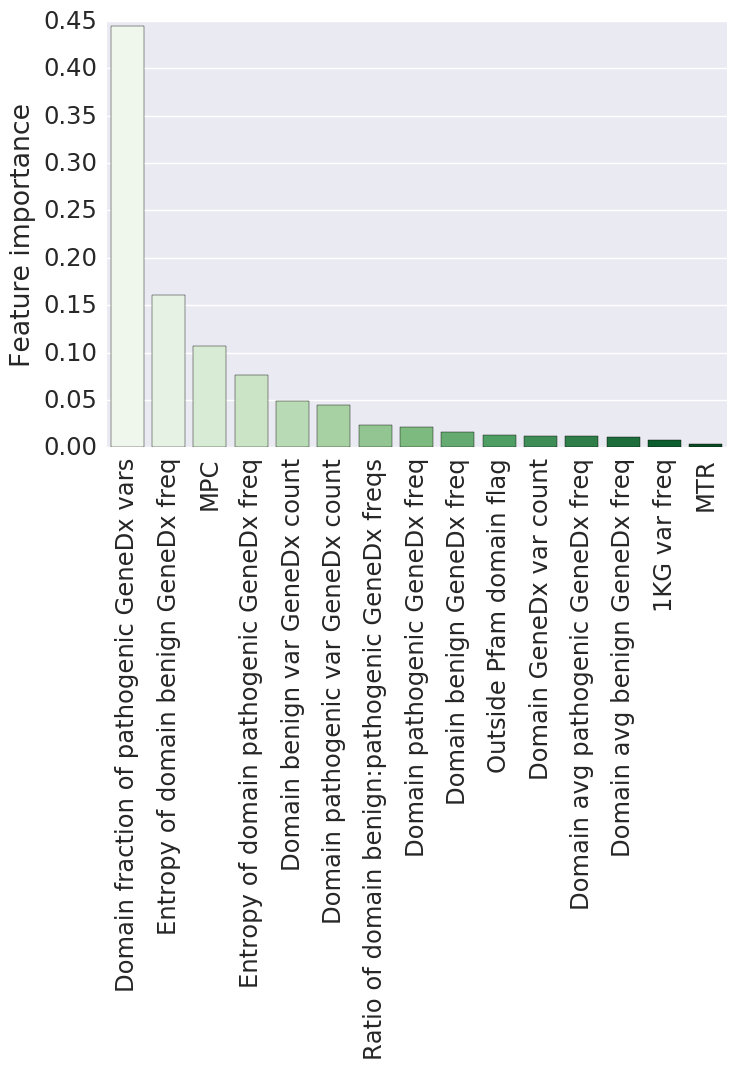

In [46]:
def eval_pred(row, col):
    if row[col]>.9:
        return 'right'
    if row[col]<.1:
        return 'wrong'
    return 'vus'

# train new tree and apply to clinvar
forest = ExtraTreesClassifier(n_estimators=300,
                                  random_state=13,
                                  bootstrap=True,
                                  max_features=7,
                                  min_samples_split=2,
                                  max_depth=8,
                                  min_samples_leaf=5,
                                  n_jobs=4)
#tree_clf = linear_model.LogisticRegression(penalty='l1', fit_intercept=True)
#poly = PolynomialFeatures(degree=6, interaction_only=False, include_bias=False)

all_preds = []
all_truth = []
# 
cols = ['mpc', 'size_t', 'path_frac_t', 'in_none_pfam',
        'path_freq', 'path_avg', 'path_ent', 'path_cnt',
        'benign_freq', 'benign_avg', 'benign_ent', 'benign_cnt',
        'af_1kg_all', 'mtr', 'path_benign_freq_r']
X, y = df_x[cols], df_x['y']
forest.fit(X, y)
#tree_clf.fit(X, y)

X_clin = clinvar_df[cols]
preds = forest.predict(X_clin)
clinvar_df['tree_pred'] = preds
clinvar_df.loc[:, 'PredictionStatus'] = clinvar_df.apply(lambda row: eval_pred(row, 'tree_pred'), axis=1)

import collections
print( 'scores', collections.Counter(clinvar_df['PredictionStatus']) )

importances = forest.feature_importances_
std = numpy.std([atree.feature_importances_ for atree in forest.estimators_],
                 axis=0)
indices = numpy.argsort(importances)[::-1]
# Print the feature ranking
feature_ls = []

print("Feature ranking:")
for f in range(X.shape[1]):
    ls = (cols[indices[f]],
                  f + 1, indices[f],
                  importances[indices[f]])
    print("%s, %d. feature %d (%f)" % ls)
    feature_ls.append([ls[0], ls[-1]])
fhash={'mpc':'MPC',
       'size_t':'Domain GeneDx var count', 
       'path_na_t':'No variants', 
       'path_frac_t':'Domain fraction of pathogenic GeneDx vars',
       'in_none_pfam':'Outside Pfam domain flag',
       'path_freq':'Domain pathogenic GeneDx freq', 
       'path_avg':'Domain avg pathogenic GeneDx freq', 
       'path_ent':'Entropy of domain pathogenic GeneDx freq',
       'path_cnt':'Domain pathogenic var GeneDx count',
       'benign_freq':'Domain benign GeneDx freq', 
       'benign_avg':'Domain avg benign GeneDx freq',
       'benign_ent':'Entropy of domain benign GeneDx freq',
       'benign_cnt':'Domain benign var GeneDx count',
       'af_1kg_all':'1KG var freq',
       'mtr':'MTR',
       'path_benign_freq_r':'Ratio of domain benign:pathogenic GeneDx freqs'}    
feature_df = pandas.DataFrame({'feature':[fhash[x[0]] for x in feature_ls], 'importance':[x[1] for x in feature_ls]})
ax = sns.barplot(data=feature_df, x='feature', y='importance', palette="Greens")
ax.set_ylabel('Feature importance')
ax.set_xlabel('')
#ax.set_title('ClinVar subset (w/o GeneDx) testing data')
plt.xticks(rotation=90)

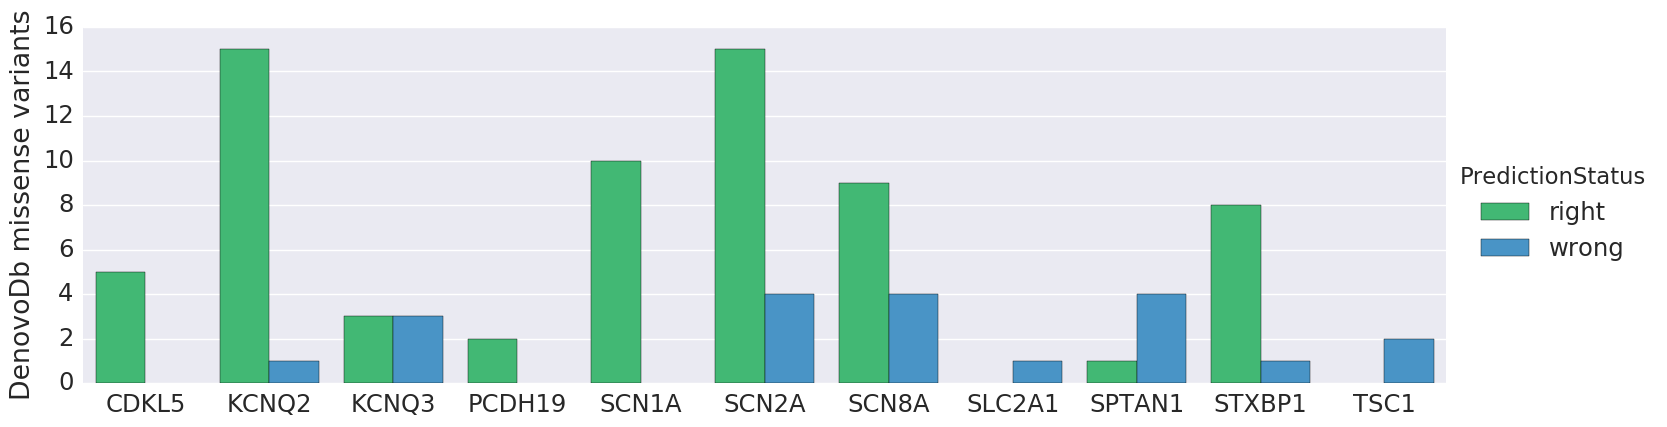

In [42]:
#plt.rcParams['figure.figsize'] = 20, 6
#plt.figure(figsize=(40,6))
#f, ax = plt.subplots(figsize=(40,6))
#sns.set_context("talk")
g_df = (clinvar_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatus']]
        .groupby(['gene','PredictionStatus'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()
use_genes = set(dd[dd['size']>0]['gene'].values)
g_df.loc[:, 'keep'] = g_df.apply(lambda row: row['gene'] in use_genes, axis=1)
sns.set(font_scale=1.75)
flatui = ["#2ecc71",  "#3498db",  "#e74c3c",]
ss = sns.factorplot(x='gene', hue='PredictionStatus', y='size', data=g_df[g_df['keep']],
                    kind='bar', palette=sns.color_palette(flatui), size=5, aspect=3)
ss.set_ylabels('DenovoDb missense variants')
ss.set_xlabels('')
ss.set_titles('Dominan burden + MPC performance')
ss.savefig("../docs/plots/denovo_burden_gene_eval.png")

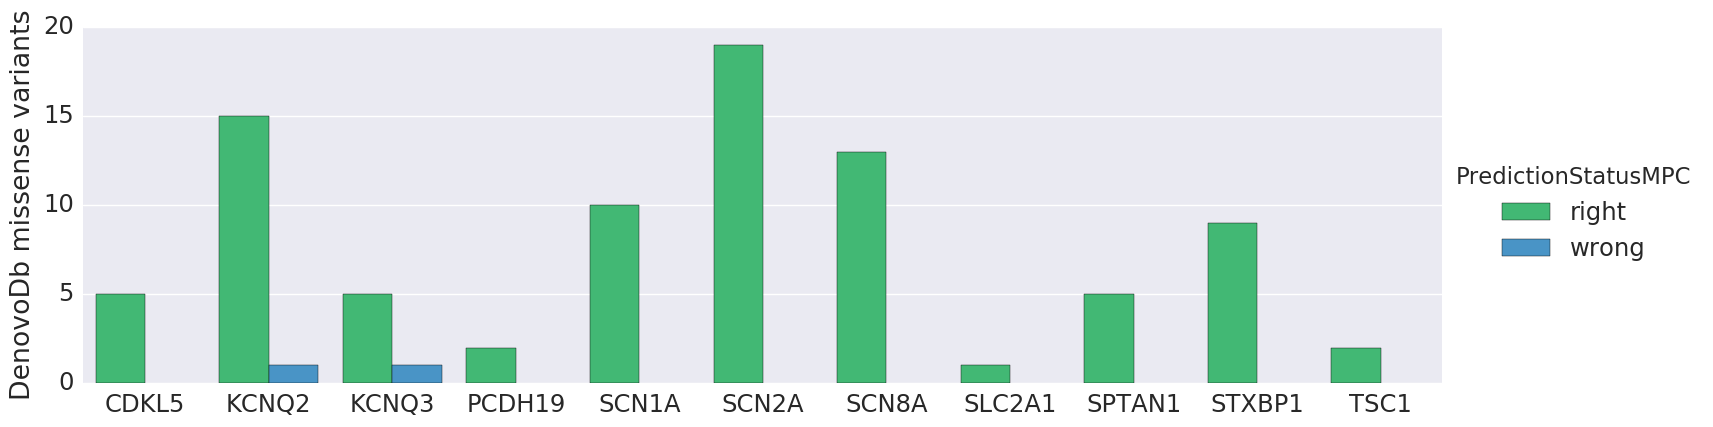

In [45]:
# train new tree and apply to clinvar: just pathogenic frac
tree_clf = tree.DecisionTreeClassifier(max_depth=1)
all_preds = []
all_truth = []
cols = ['mpc', 'size_t', 'path_na_t', 'path_frac_t']
X, y = df_x[cols], df_x['y']
tree_clf.fit(X, y)

all_preds = []
all_truth = []
cols =  ['mpc']
X, y = df_x[cols], df_x['y'] #X, y = df_x[cols], df_x['y']
tree_clf.fit(X, y)

X_clin = clinvar_df[cols]
preds = tree_clf.predict(X_clin)
clinvar_df['mpc_pred'] = preds
clinvar_df.loc[:, 'PredictionStatusMPC'] = clinvar_df.apply(lambda row: eval_pred(row, 'mpc_pred'), axis=1)
g_df = (clinvar_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC']]
        .groupby(['gene','PredictionStatusMPC'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()
use_genes = set(dd[dd['size']>0]['gene'].values)
g_df.loc[:, 'keep'] = g_df.apply(lambda row: row['gene'] in use_genes, axis=1)
sns.set(font_scale=1.75)
flatui = ["#2ecc71",  "#3498db",  "#e74c3c",]
ss = sns.factorplot(x='gene', hue='PredictionStatusMPC', y='size', data=g_df[g_df['keep']],
                    kind='bar', palette=sns.color_palette(flatui), size=5, aspect=3)
ss.set_ylabels('DenovoDb missense variants')
ss.set_xlabels('')
ss.set_titles('MPC performance')
ss.savefig("../docs/plots/denovo_mpc_eval.png")

In [21]:
scores = clinvar_df['mpc'].values
truth = clinvar_df['y'].values
fpr_mpc, tpr_mpc, _ = metrics.roc_curve(truth, scores, pos_label=1)
mpc_auc = metrics.auc(fpr_mpc, tpr_mpc)

In [47]:
import collections
print( 'mpc', collections.Counter(clinvar_df['PredictionStatusMPC']) )
print( 'new', collections.Counter(clinvar_df['PredictionStatus']) )

mpc Counter({'right': 86, 'wrong': 2})
new Counter({'right': 68, 'wrong': 20})
